# Andmete ettevalmistus RAG-süsteemi jaoks

See märkmik viib TÜ ÕISi toore kursusandmestiku (`toorandmed_aasta.csv`) RAG-süsteemile sobivasse kujusse.

**Sammud:**
1. Laadi toored andmed
2. Vali ja nimeta ümber vajalikud veerud
3. Puhasta andmed (NaN, tüübid, duplikaadid)
4. Filtreeri välja ebasobivad kursused (täiendõpe, kaitsmisained)
5. Ehita `rag_text` — kahekeelne tekstitükk iga aine kohta
6. Salvesta väljundid
7. Visualiseeri `rag_text` pikkuste jaotust

## 1. Importid ja konfiguratsioon

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import os

RAW_PATH         = 'data/toorandmed_aasta.csv'
OUT_PARQUET      = 'data/rag_courses.parquet'
OUT_CSV          = 'data/rag_courses.csv'
OUT_FILT_PARQUET = 'data/rag_courses_filtered.parquet'
OUT_FILT_CSV     = 'data/rag_courses_filtered.csv'
PLOT_PATH        = 'data/rag_text_length_distribution.png'

print('Konfiguratsioon OK')

Konfiguratsioon OK


## 2. Lae toored andmed

In [2]:
df_raw = pd.read_csv(RAW_PATH, low_memory=False)
print(f'Toored andmed: {df_raw.shape[0]:,} rida × {df_raw.shape[1]} veergu')
df_raw.head(2)

Toored andmed: 3,156 rida × 229 veergu


,course_uuid,code,title__en,version__title__en,credits,overview__description__en,version__overview__description__en,overview__learning_outcomes_text_en,uuid,state__code,...,overview__description__de,overview__description__da,version__overview__description__da,version__target__faculty__is_expired,overview__objectives_text_et,overview__learning_outcomes_text_et,version__overview__objectives_text_et,version__overview__learning_outcomes_text_et,title__de,version__title__de
0,b99c0bb1-efd4-9b0a-857a-3dc7114e5c19,OIEO.06.046,Private International Law,Private International Law,6.0,The course covers the main topics of private i...,The course covers the main topics of private i...,- At the end of the course the student is able...,b99c0bb1-efd4-9b0a-857a-3dc7114e5c19,confirmed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0e7d0b5d-83ea-f260-7e09-c3d59ea9c250,KKSB.05.092,Practice in the Work Environment,Practice in the Work Environment,3.0,Subject Practicing in the work environment the...,Subject Practicing in the work environment the...,- Student:\n- understands and follows the work...,0e7d0b5d-83ea-f260-7e09-c3d59ea9c250,confirmed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Vali ja nimeta ümber vajalikud veerud

Valime 25 veergu, mis on RAG-i ja filtreerimise jaoks olulised, ning anname neile lühemad nimed.

In [3]:
# Mapping: uus_nimi -> algne_veerunimi
COL_MAP = {
    'course_uuid':          'course_uuid',
    'code':                 'code',
    'title_en':             'title__en',
    'title_et':             'title__et',
    'eap':                  'credits',
    'duration_semesters':   'additional_info__duration_in_semesters',
    'semester':             'version__target__semester__en',
    'city':                 'version__target__faculty__city',
    'target_language':      'version__target__language__en',
    'assessment_scale':     'additional_info__assessment_scale__en',
    'course_type':          'general__type__en',
    'is_continuous_learning': 'additional_info__is_continuous_learning_course',
    'study_languages_en':   'general__input_languages',
    'study_levels_en':      'version__additional_info__study_levels',
    'description_en':       'overview__description__en',
    'description_et':       'overview__description__et',
    'objectives_en':        'overview__objectives_text_en',
    'objectives_et':        'overview__objectives_text_et',
    'outcomes_en':          'overview__learning_outcomes_text_en',
    'outcomes_et':          'overview__learning_outcomes_text_et',
    'prerequisites_text':   'additional_info__prerequisites',
}

# Keep only columns that exist in the raw data
valid_map = {new: old for new, old in COL_MAP.items() if old in df_raw.columns}
missing   = {new: old for new, old in COL_MAP.items() if old not in df_raw.columns}
if missing:
    print('Puuduvad veerud (jäetakse vahele):', missing)

df = df_raw[list(valid_map.values())].copy()
df.columns = list(valid_map.keys())
print(f'Valitud {len(df.columns)} veergu, {len(df):,} rida')
df.dtypes

Valitud 21 veergu, 3,156 rida


course_uuid                object
code                       object
title_en                   object
title_et                   object
eap                       float64
duration_semesters          int64
semester                   object
city                       object
target_language            object
assessment_scale           object
course_type                object
is_continuous_learning       bool
study_languages_en         object
study_levels_en            object
description_en             object
description_et             object
objectives_en              object
objectives_et              object
outcomes_en                object
outcomes_et                object
prerequisites_text         object
dtype: object

## 4. Puhasta andmed

In [4]:
# --- 4a. Tekstiveerud: NaN → tühi string ---
text_cols = [
    'title_en', 'title_et',
    'description_en', 'description_et',
    'objectives_en', 'objectives_et',
    'outcomes_en', 'outcomes_et',
    'prerequisites_text',
    'city', 'target_language', 'assessment_scale', 'course_type',
]
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].fillna('').astype(str).str.strip()

# --- 4b. Numbrilised veerud ---
if 'eap' in df.columns:
    df['eap'] = pd.to_numeric(df['eap'], errors='coerce')
if 'duration_semesters' in df.columns:
    df['duration_semesters'] = pd.to_numeric(df['duration_semesters'], errors='coerce')

# --- 4c. Boolean ---
if 'is_continuous_learning' in df.columns:
    df['is_continuous_learning'] = df['is_continuous_learning'].astype(bool)

# --- 4d. Semester: normaliseeri →  'spring' / 'autumn' / '' ---
if 'semester' in df.columns:
    df['semester'] = df['semester'].fillna('').astype(str).str.strip().str.lower()

# --- 4e. study_languages_en: list-string → loetav string ---
# Toores veerus on nt [{'code':'et','en':'Estonian'},...]
def parse_languages(val):
    if not val or val in ('nan', ''):
        return ''
    try:
        items = ast.literal_eval(str(val))
        if isinstance(items, list):
            langs = []
            for item in items:
                if isinstance(item, dict):
                    langs.append(item.get('en') or item.get('et') or '')
                else:
                    langs.append(str(item))
            return ', '.join(filter(None, langs))
    except Exception:
        pass
    return str(val).strip()

if 'study_languages_en' in df.columns:
    df['study_languages_en'] = df['study_languages_en'].apply(parse_languages)

# --- 4f. study_levels_en: list-string → loetav string ---
def parse_levels(val):
    if not val or str(val) in ('nan', ''):
        return ''
    try:
        items = ast.literal_eval(str(val))
        if isinstance(items, list):
            levels = []
            for item in items:
                if isinstance(item, dict):
                    levels.append(item.get('en') or item.get('et') or '')
                else:
                    levels.append(str(item))
            return ', '.join(filter(None, levels))
    except Exception:
        pass
    return str(val).strip()

if 'study_levels_en' in df.columns:
    df['study_levels_en'] = df['study_levels_en'].apply(parse_levels)

# --- 4g. Eemalda duplikaadid (samad course_uuid) ---
before = len(df)
df = df.drop_duplicates(subset='course_uuid', keep='first')
print(f'Duplikaate eemaldatud: {before - len(df)} (järel {len(df):,} rida)')

print('\nNaN-ide arv veergude kaupa:')
print(df.isnull().sum()[df.isnull().sum() > 0])

Duplikaate eemaldatud: 173 (järel 2,983 rida)

NaN-ide arv veergude kaupa:
Series([], dtype: int64)


## 5. Ehita `rag_text`

Iga aine kohta koostatakse üks kahekeelne tekstitükk, mis on embeddingu mudeli sisendiks.

In [5]:
def build_rag_text(row) -> str:
    """Koosta struktureeritud RAG-tekst ühe aine kohta."""
    parts = []

    # Identifikaatorid
    parts.append(f"Course code: {row.get('code', '')}")
    if row.get('title_en'):
        parts.append(f"Title (EN): {row['title_en']}")
    if row.get('title_et'):
        parts.append(f"Title (ET): {row['title_et']}")

    # Metaandmed
    if pd.notna(row.get('eap')):
        parts.append(f"Credits (ECTS): {row['eap']}")
    if pd.notna(row.get('duration_semesters')):
        parts.append(f"Duration (semesters): {int(row['duration_semesters'])}")
    if row.get('semester'):
        parts.append(f"Semester: {row['semester']}")
    if row.get('city'):
        parts.append(f"City: {row['city']}")
    if row.get('target_language'):
        parts.append(f"Target language: {row['target_language']}")
    if row.get('study_languages_en'):
        parts.append(f"Study languages: {row['study_languages_en']}")
    if row.get('study_levels_en'):
        parts.append(f"Study levels: {row['study_levels_en']}")
    if row.get('assessment_scale'):
        parts.append(f"Assessment: {row['assessment_scale']}")
    if row.get('course_type'):
        parts.append(f"Course type: {row['course_type']}")

    # Sisu (mõlemas keeles)
    for label, key in [
        ('Description (EN)', 'description_en'),
        ('Description (ET)', 'description_et'),
        ('Objectives (EN)',  'objectives_en'),
        ('Objectives (ET)',  'objectives_et'),
        ('Outcomes (EN)',    'outcomes_en'),
        ('Outcomes (ET)',    'outcomes_et'),
        ('Prerequisites',   'prerequisites_text'),
    ]:
        val = str(row.get(key, '')).strip()
        if val and val != 'nan':
            parts.append(f"{label}: {val}")

    return '\n'.join(parts)


df['rag_text']     = df.apply(build_rag_text, axis=1)
df['rag_text_len'] = df['rag_text'].str.len()

print(f'rag_text ehitatud: {len(df):,} ainet')
print(f'Pikkus (tähemärki): min={df.rag_text_len.min()}, '
      f'mediaan={df.rag_text_len.median():.0f}, '
      f'max={df.rag_text_len.max()}')
print('\nNäide (esimene aine):')
print(df['rag_text'].iloc[0])

rag_text ehitatud: 2,983 ainet
Pikkus (tähemärki): min=396, mediaan=2256, max=8419

Näide (esimene aine):
Course code: OIEO.06.046
Title (EN): Private International Law
Title (ET): Rahvusvaheline eraõigus
Credits (ECTS): 6.0
Duration (semesters): 1
Semester: spring
City: Tartu linn
Target language: Estonian
Study languages: Estonian
Study levels: master's studies
Assessment: differentiated (A, B, C, D, E, F, not present)
Course type: Regular course
Description (EN): The course covers the main topics of private international law (PIL), its terminology and development. The instruments which govern the determination of international jurisdiction and the applicable law in Estonia, as well as their most relevant norms, will be covered with the aim of teaching students to use them in practice (the Hague conventions, other international agreements that are binding to the Republic of Estonia, relevant EU law and Estonian legal acts).
Description (ET): Kursuse raames käsitletakse rahvusvahelise

## 6. Salvesta täielik puhastatud andmestik

In [6]:
os.makedirs('data', exist_ok=True)
df.to_parquet(OUT_PARQUET, index=False)
df.to_csv(OUT_CSV, index=False)
print(f'Salvestatud: {OUT_PARQUET}  ({len(df):,} ainet × {len(df.columns)} veergu)')
print(f'Salvestatud: {OUT_CSV}')

Salvestatud: data/rag_courses.parquet  (2,983 ainet × 23 veergu)
Salvestatud: data/rag_courses.csv


## 7. Filtreeri ebasobivad kursused

Äriloogika filtrid:
- **Täiendõppe ained** (`is_continuous_learning = True`) — 985 tk — ei kuulu sihtrühma (tavalised bakalaureuseõppe jne tudengid)
- **Kaitsmisained** (`course_type = 'Course with defence at the end'` ehk `general__type__code = 'defence'`) — 58 tk — ei ole pärisained

In [7]:
print('Enne filtreerimist:', len(df), 'ainet')
print('course_type jaotus:')
print(df['course_type'].value_counts())
print()
print('is_continuous_learning jaotus:')
print(df['is_continuous_learning'].value_counts())

Enne filtreerimist: 2983 ainet
course_type jaotus:
course_type
Regular course                    2807
Working practice                   119
Course with defence at the end      53
Complex course                       4
Name: count, dtype: int64

is_continuous_learning jaotus:
is_continuous_learning
False    2076
True      907
Name: count, dtype: int64


In [8]:
# Filter 1: eemalda täiendõppe ained
mask_cont = df['is_continuous_learning'] == True
print(f'Täiendõppe ained (eemaldatakse): {mask_cont.sum()}')

# Filter 2: eemalda kaitsmisained
# course_type veerus on ingliskeelne nimi; kontrollime mõlemat võimalikku väärtust
mask_defence = df['course_type'].str.lower().str.contains('defence', na=False)
print(f'Kaitsmisained (eemaldatakse): {mask_defence.sum()}')

df_filtered = df[~mask_cont & ~mask_defence].copy()
df_filtered = df_filtered.reset_index(drop=True)

print(f'\nPärast filtreerimist: {len(df_filtered):,} ainet')
print('course_type jaotus pärast filtreerimist:')
print(df_filtered['course_type'].value_counts())

Täiendõppe ained (eemaldatakse): 907
Kaitsmisained (eemaldatakse): 53

Pärast filtreerimist: 2,023 ainet
course_type jaotus pärast filtreerimist:
course_type
Regular course      1901
Working practice     118
Complex course         4
Name: count, dtype: int64


In [9]:
df_filtered.to_parquet(OUT_FILT_PARQUET, index=False)
df_filtered.to_csv(OUT_FILT_CSV, index=False)
print(f'Salvestatud: {OUT_FILT_PARQUET}  ({len(df_filtered):,} ainet × {len(df_filtered.columns)} veergu)')
print(f'Salvestatud: {OUT_FILT_CSV}')

Salvestatud: data/rag_courses_filtered.parquet  (2,023 ainet × 23 veergu)
Salvestatud: data/rag_courses_filtered.csv


## 8. Visualiseeri `rag_text` pikkuste jaotus

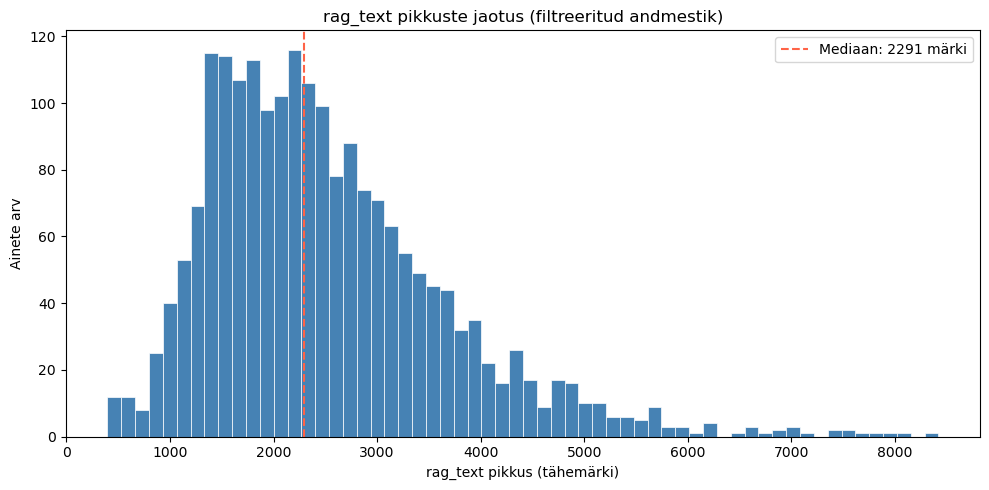

Joonis salvestatud: data/rag_text_length_distribution.png


In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df_filtered['rag_text_len'], bins=60, color='steelblue', edgecolor='white', linewidth=0.5)
ax.axvline(df_filtered['rag_text_len'].median(), color='tomato', linestyle='--',
           label=f"Mediaan: {df_filtered['rag_text_len'].median():.0f} märki")
ax.set_xlabel('rag_text pikkus (tähemärki)')
ax.set_ylabel('Ainete arv')
ax.set_title('rag_text pikkuste jaotus (filtreeritud andmestik)')
ax.legend()
plt.tight_layout()
plt.savefig(PLOT_PATH, dpi=150)
plt.show()
print(f'Joonis salvestatud: {PLOT_PATH}')

## Kokkuvõte

| Fail | Kirjeldus | Aineid |
|------|-----------|-------|
| `data/rag_courses.parquet` | Puhastatud täielik andmestik | ~3 156 |
| `data/rag_courses_filtered.parquet` | RAG-süsteemi sisend (täiendõpe + kaitsmine eemaldatud) | ~2 113 |

Järgmine samm: käivita `build_vectorstore.py`, mis embeddib `rag_text` veerud ja ehitab ChromaDB vektorandmebaasi.